# Import Libraries

In [1]:
import pandas as pd
import yfinance as yf
from datetime import date, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:

# List of stock tickers to download
tickers = ['VTI', 'BND', 'VXUS']

# Download data for the given tickers and time period
data = yf.download(tickers, period='1y', progress=False, group_by='ticker')

# Reset index to bring Date into the columns
etf_data = data.stack(level=0, future_stack=True).reset_index()

etf_data.head()  

Price,Date,Ticker,Open,High,Low,Close,Volume
0,2024-01-16,BND,70.601418,70.659278,70.254245,70.341042,5724700
1,2024-01-16,VXUS,54.823724,54.862428,54.456038,54.533447,3316000
2,2024-01-16,VTI,233.158276,233.770069,231.984061,232.881989,3646700
3,2024-01-17,BND,70.167447,70.244591,70.042075,70.177086,12370300
4,2024-01-17,VXUS,53.730347,53.943218,53.604563,53.933544,2601900


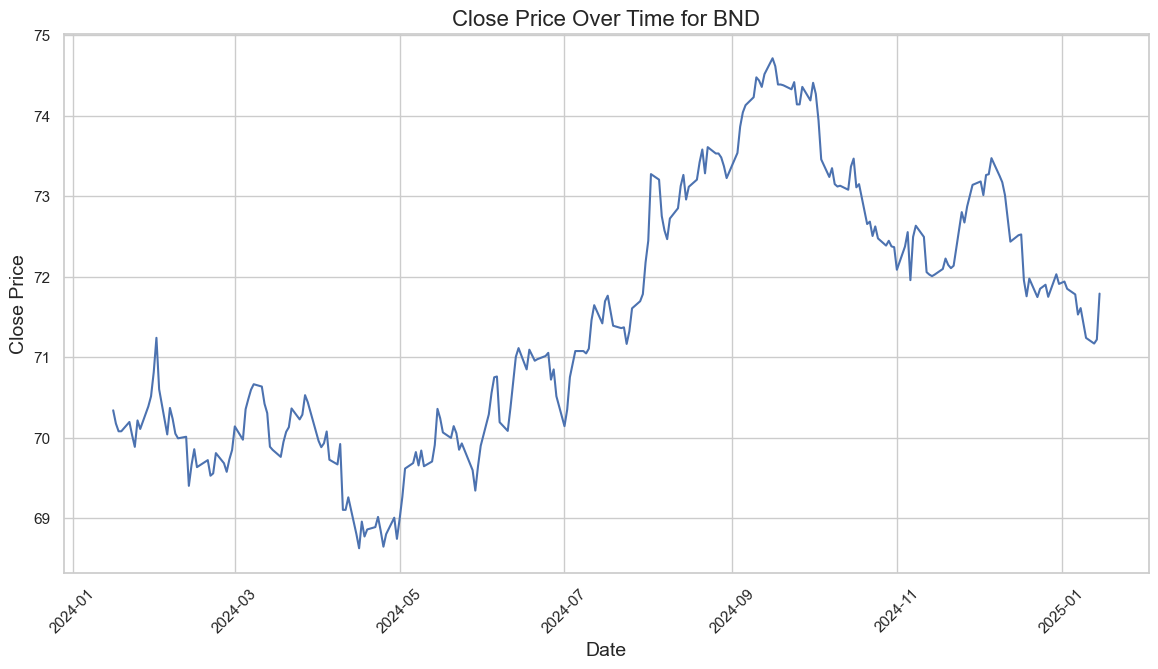

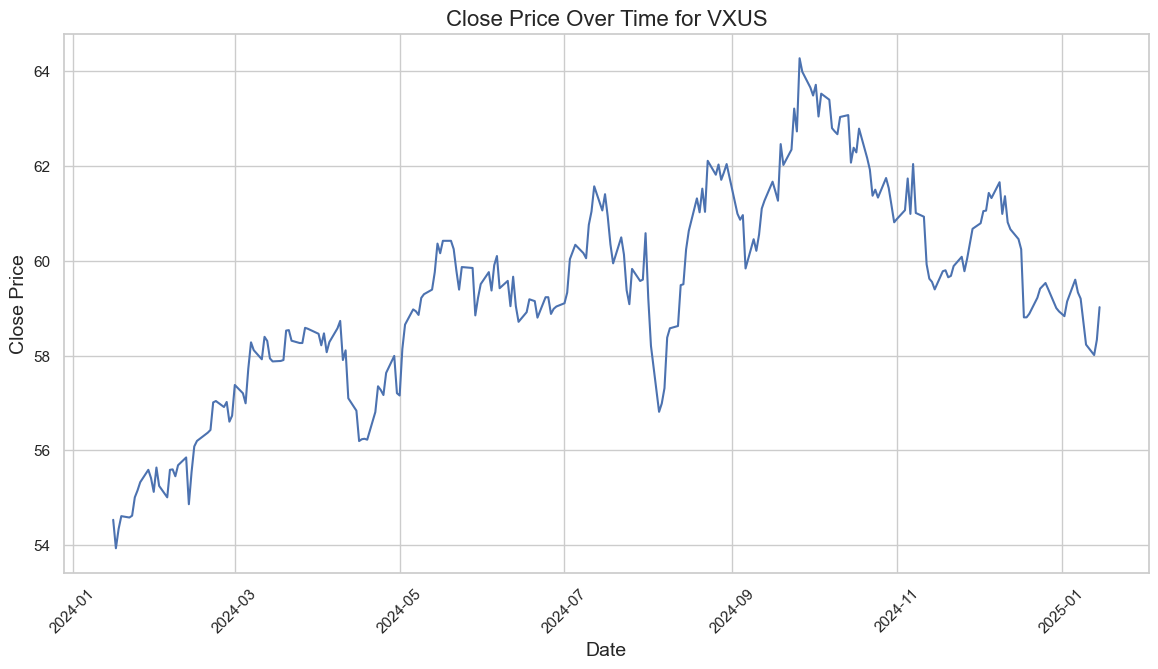

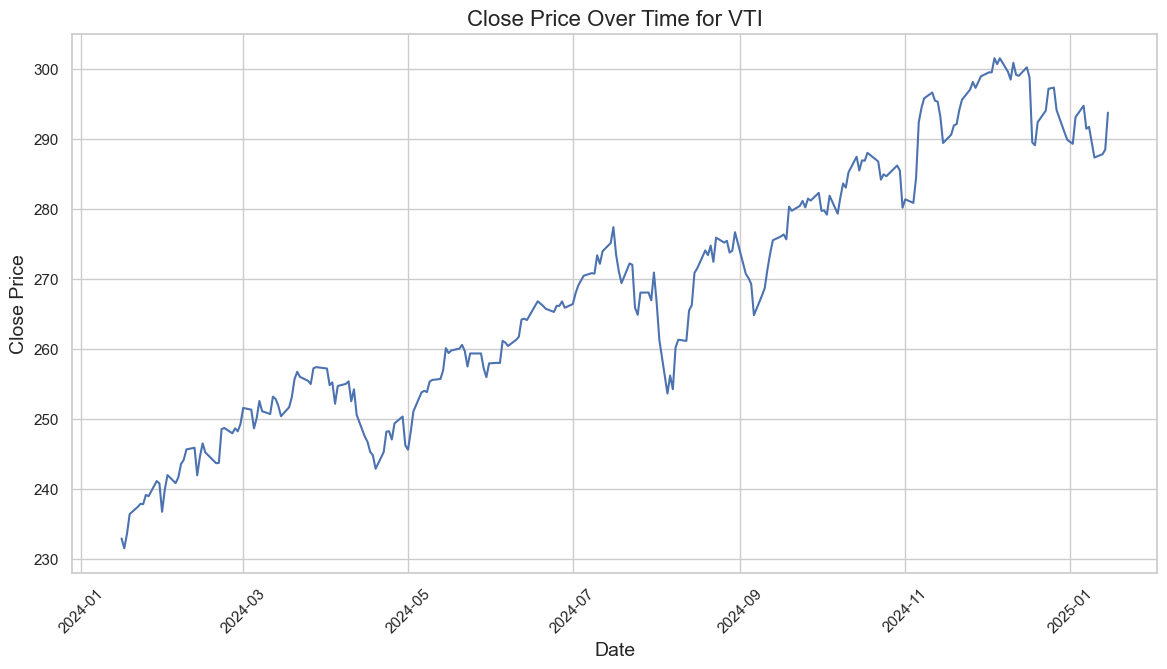

In [3]:
# Ensure stock_data is already loaded with columns 'Date', 'Close', 'Ticker'

etf_data['Date'] = pd.to_datetime(etf_data['Date'])  # Convert Date column to datetime

# Get a list of unique tickers
unique_tickers = etf_data['Ticker'].unique()

# Create a separate plot for each ticker
for ticker in unique_tickers:
    # Filter data for the current ticker
    ticker_data = etf_data[etf_data['Ticker'] == ticker]
    
    # Create the plot
    plt.figure(figsize=(14, 7))
    sns.set(style='whitegrid')
    sns.lineplot(data=ticker_data, x='Date', y='Close')

    # Add plot title and labels
    plt.title(f'Close Price Over Time for {ticker}', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Close Price', fontsize=14)

    # Rotate x-axis labels
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

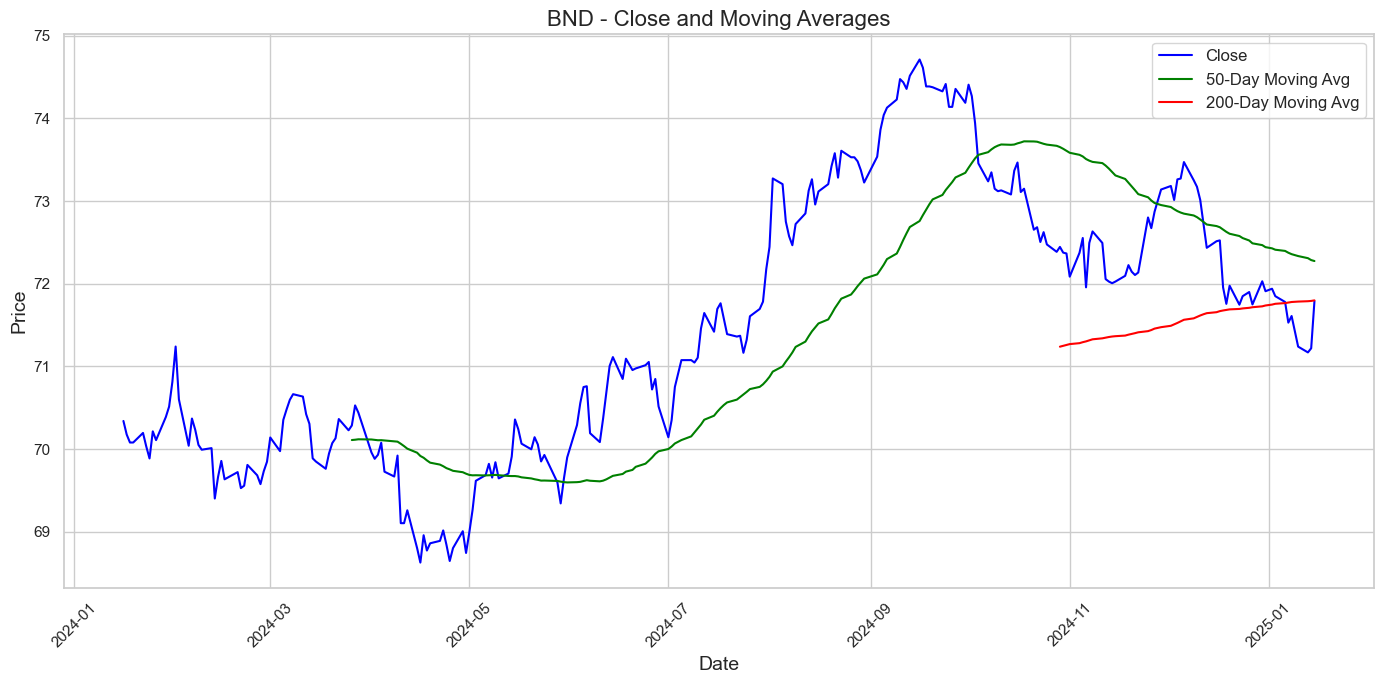

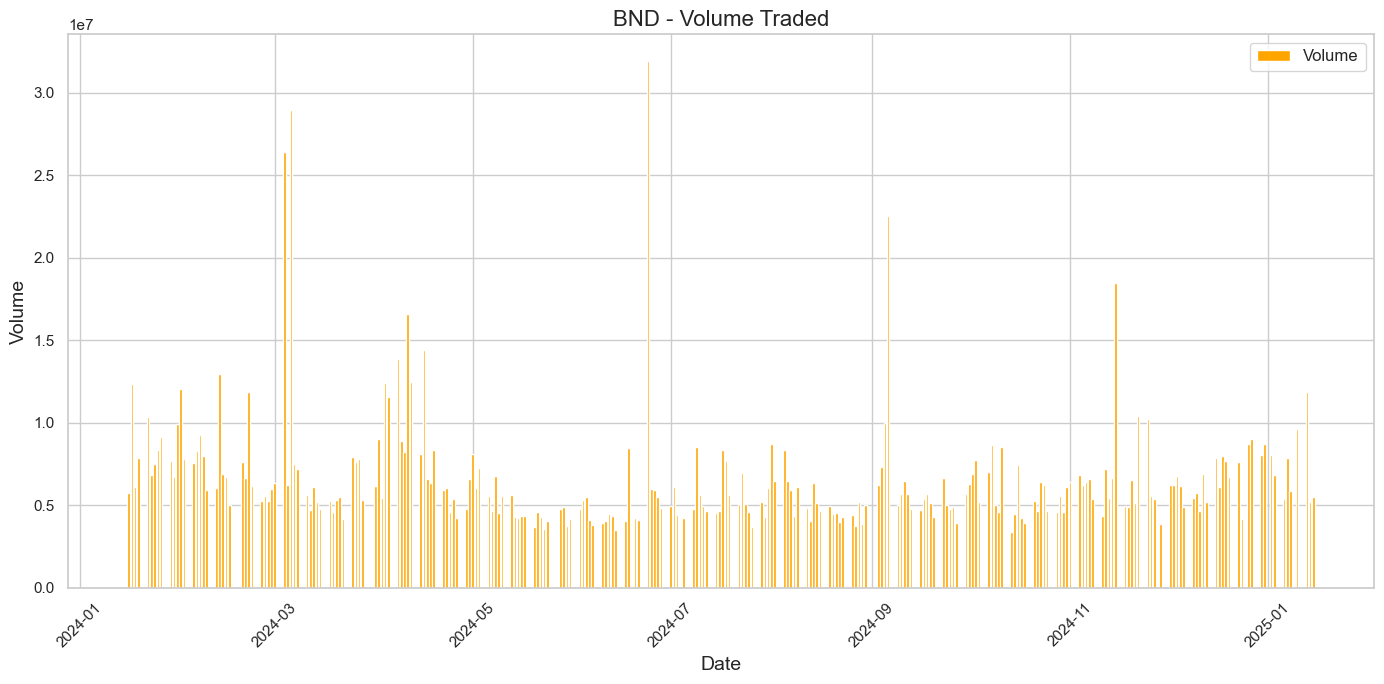

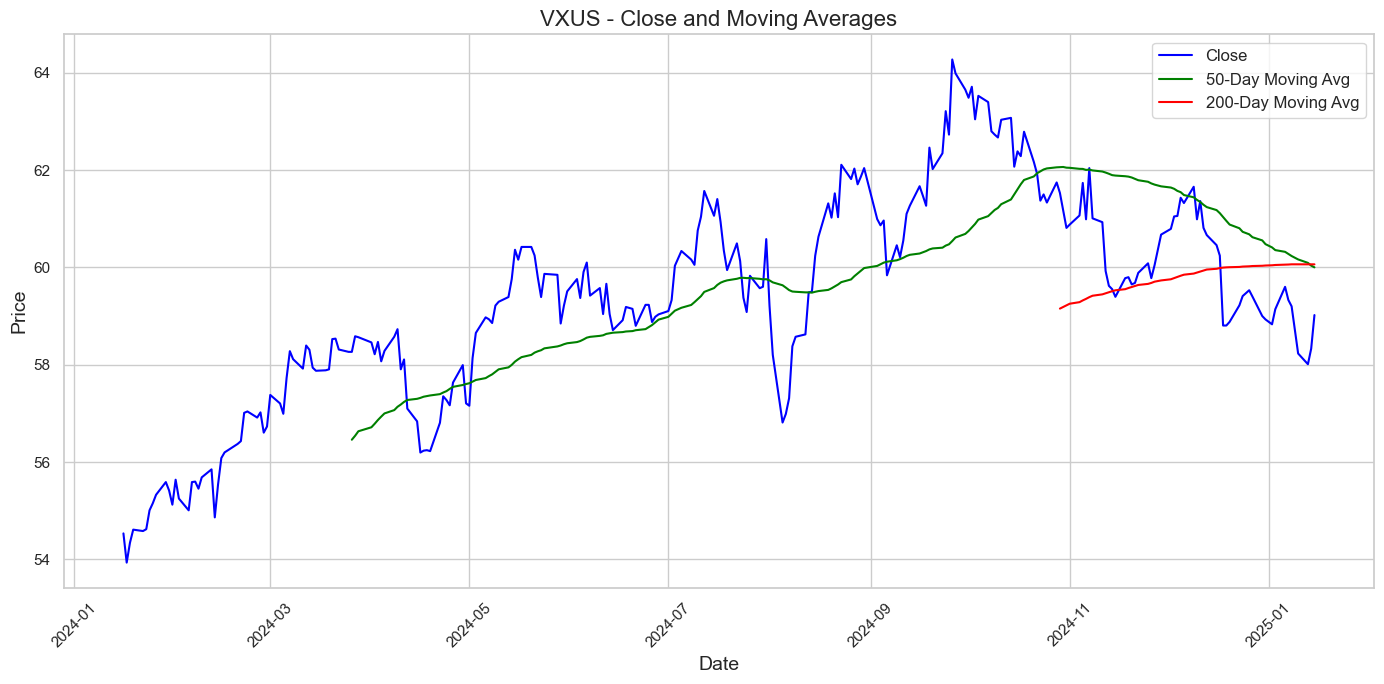

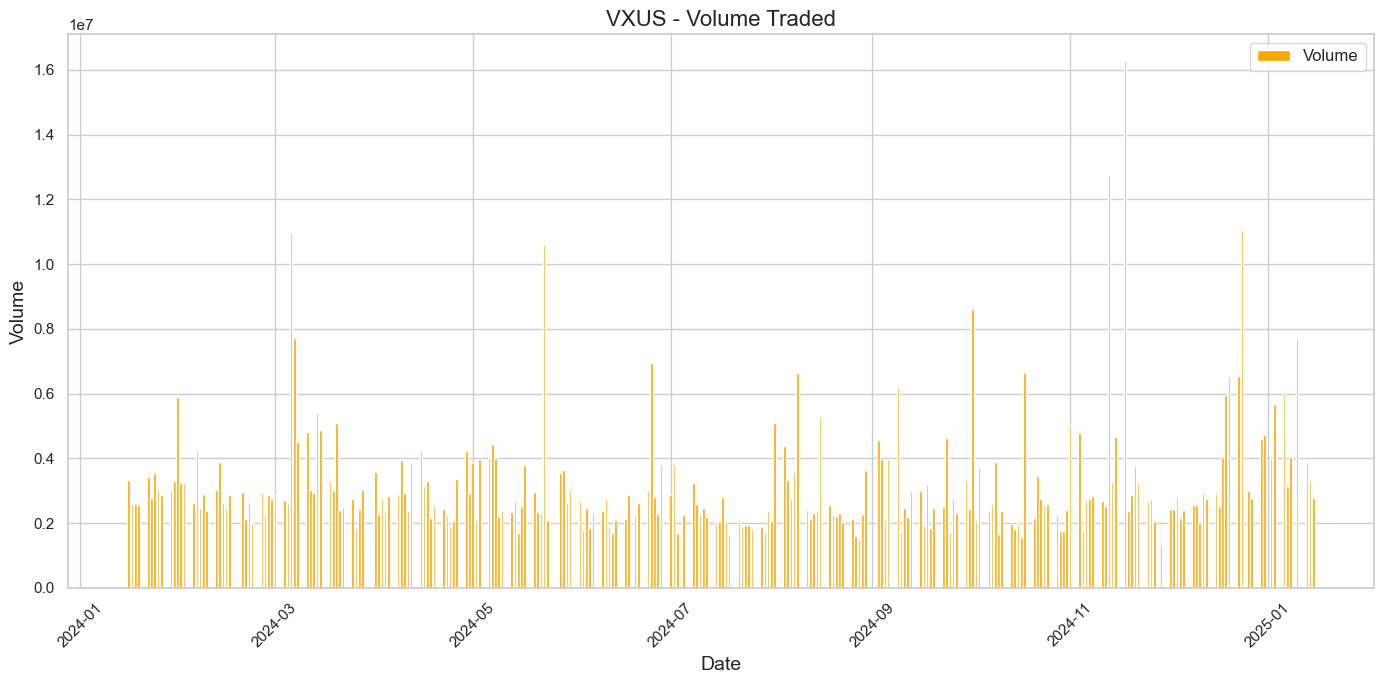

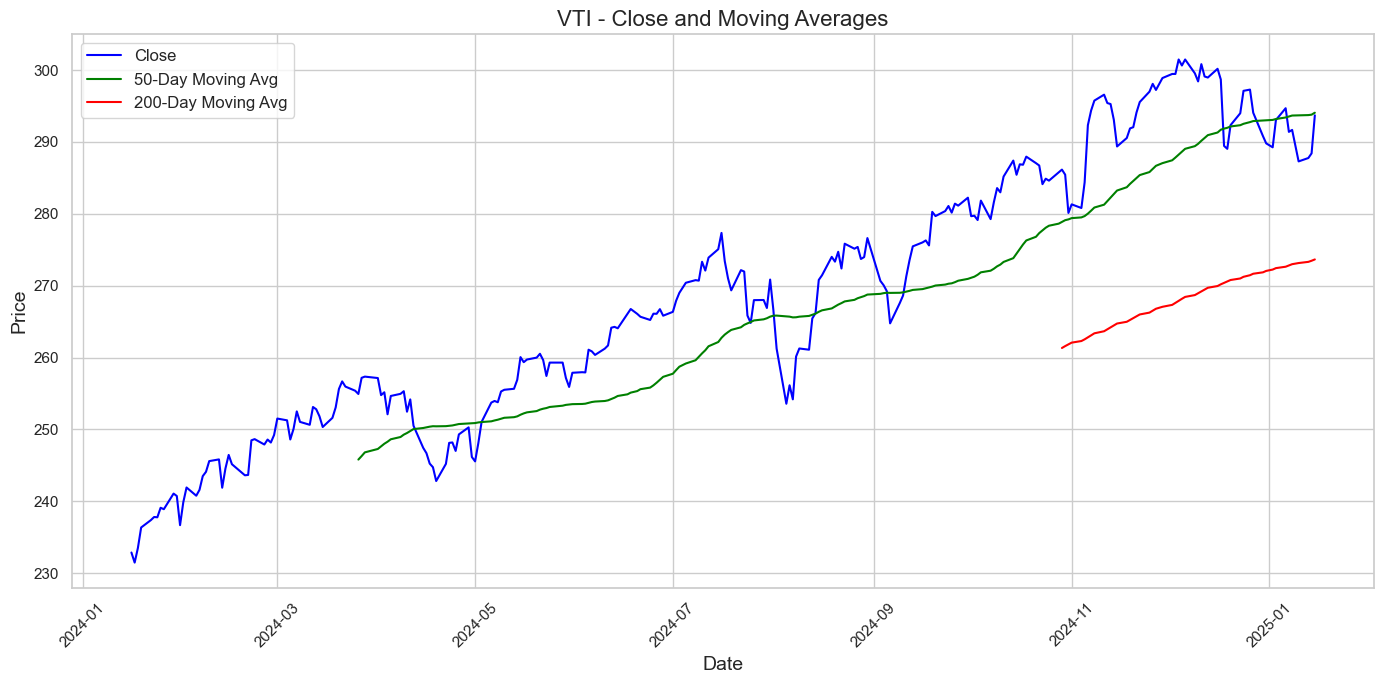

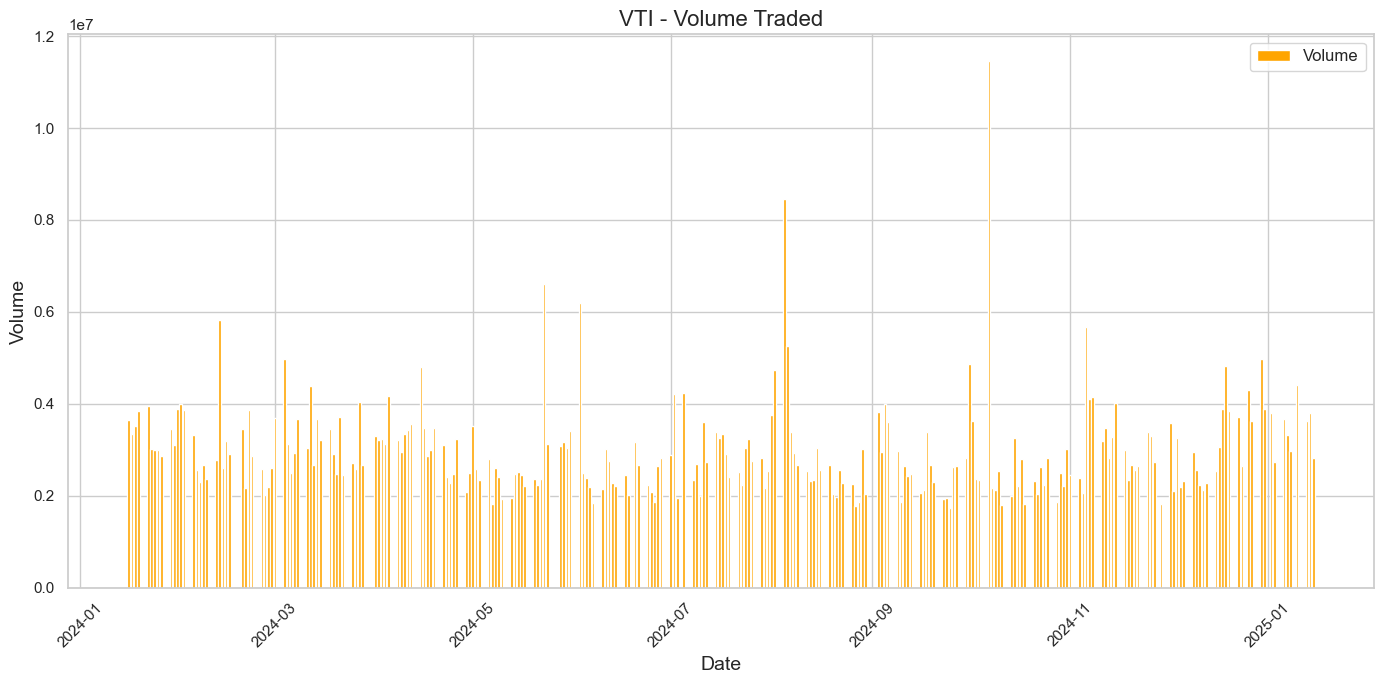

In [4]:
import matplotlib.dates as mdates

short_window = 50
long_window = 200

# Ensure stock_data is loaded with columns 'Date', 'Adj Close', 'Volume', 'Ticker'
unique_tickers = etf_data['Ticker'].unique()

for ticker in unique_tickers:
    # Filter and set Date as index
    ticker_data = etf_data[etf_data['Ticker'] == ticker].copy()
    ticker_data.set_index('Date', inplace=True)
    
    # Calculate moving averages
    ticker_data['50_MA'] = ticker_data['Close'].rolling(window=short_window).mean()
    ticker_data['200_MA'] = ticker_data['Close'].rolling(window=long_window).mean()

    # Plot Adjusted Close and Moving Averages
    plt.figure(figsize=(14, 7))
    plt.plot(ticker_data.index, ticker_data['Close'], label='Close', color='blue')
    plt.plot(ticker_data.index, ticker_data['50_MA'], label='50-Day Moving Avg', color='green')
    plt.plot(ticker_data.index, ticker_data['200_MA'], label='200-Day Moving Avg', color='red')
    plt.title(f'{ticker} - Close and Moving Averages', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Price', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Volume
    plt.figure(figsize=(14, 7))
    plt.bar(ticker_data.index, ticker_data['Volume'], label='Volume', color='orange')
    plt.title(f'{ticker} - Volume Traded', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Volume', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

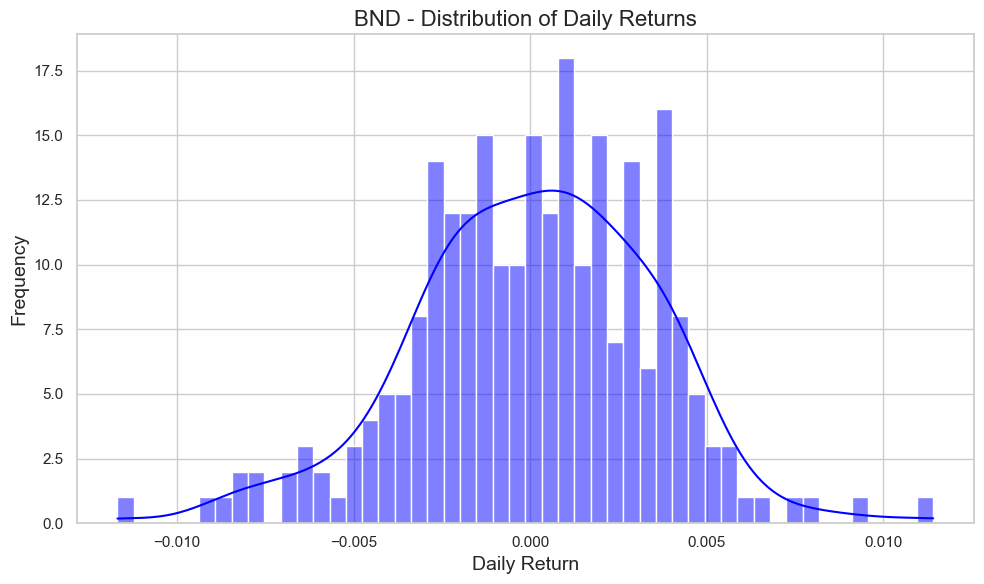

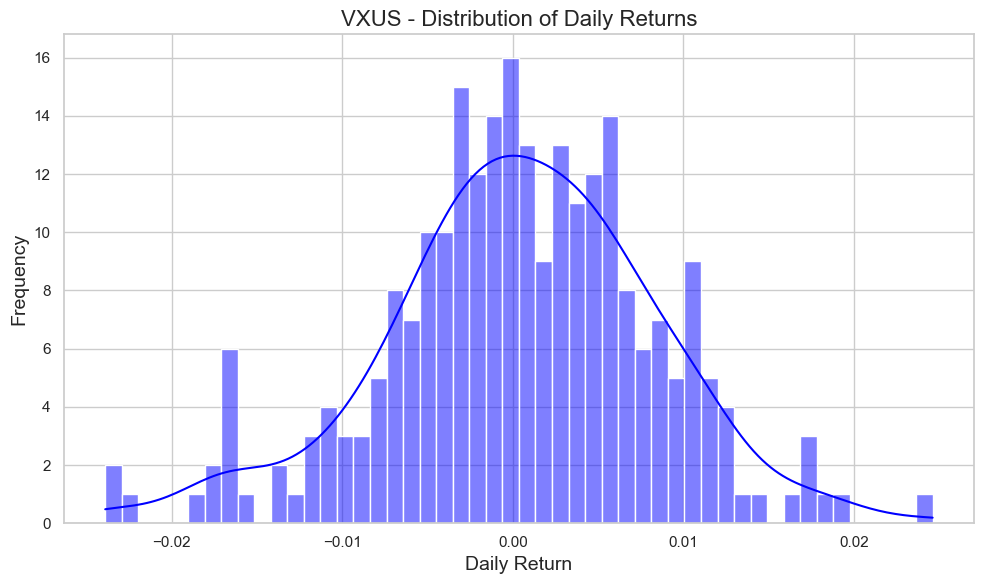

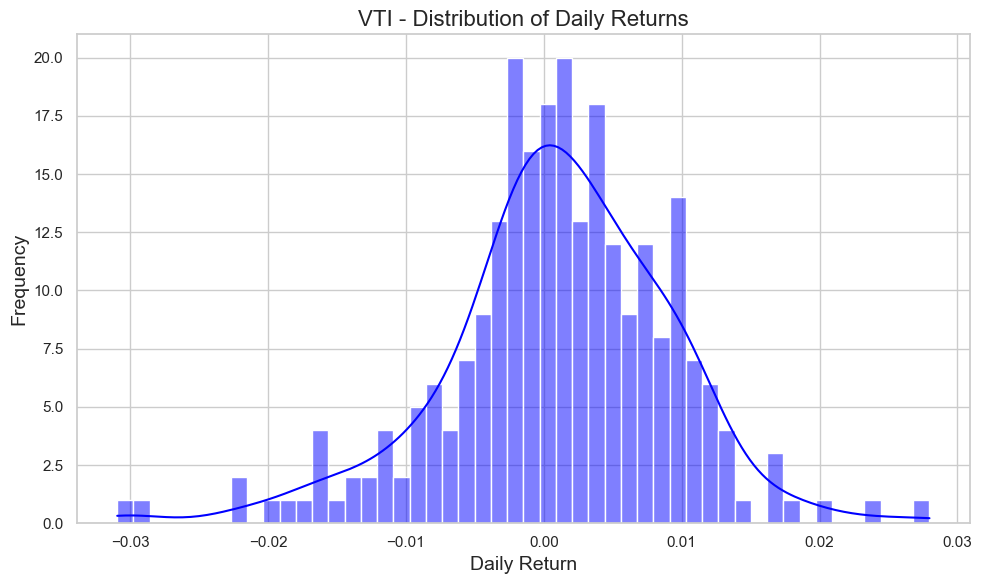

In [5]:
etf_data['Daily Return'] = etf_data.groupby('Ticker')['Close'].pct_change()

# Iterate through unique tickers and plot individual histograms
for ticker in unique_tickers:
    ticker_data = etf_data[etf_data['Ticker'] == ticker]
    
    plt.figure(figsize=(10, 6))
    sns.set(style='whitegrid')
    sns.histplot(ticker_data['Daily Return'].dropna(), bins=50, kde=True, color='blue', alpha=0.5)
    
    # Add titles and labels
    plt.title(f'{ticker} - Distribution of Daily Returns', fontsize=16)
    plt.xlabel('Daily Return', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

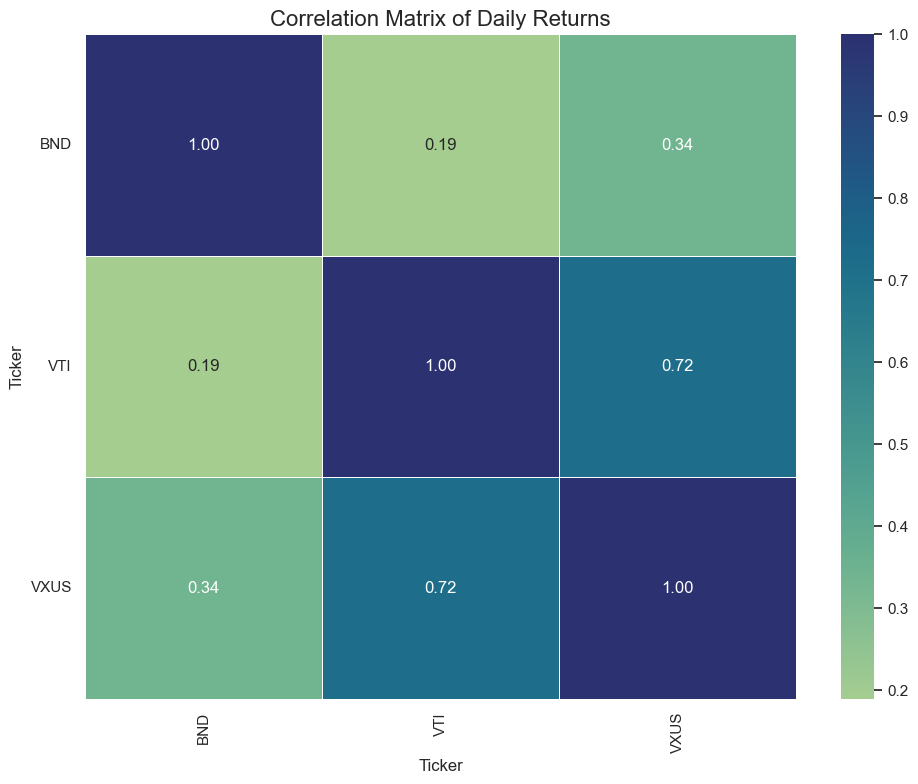

In [6]:
daily_returns = etf_data.pivot_table(index='Date', columns='Ticker', values='Daily Return')
correlation_matrix = daily_returns.corr()

plt.figure(figsize=(10, 8))
sns.set(style='whitegrid')

sns.heatmap(correlation_matrix, annot=True, cmap='crest', linewidths=.5, fmt='.2f', annot_kws={"size": 12})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Calculate expected returns and volatility

In [7]:
expected_returns = daily_returns.mean() * 252  # annualize the returns
volatility = daily_returns.std() * np.sqrt(252)  # annualize the volatility

etf_stats = pd.DataFrame({
    'Expected Return': expected_returns,
    'Volatility': volatility
})

etf_stats

,Expected Return,Volatility
Ticker,,
BND,0.021917,0.053856
VTI,0.241664,0.131058
VXUS,0.087355,0.126395


# Generate random portfolios and plot the efficient frontier

1. Generate a large number of random portfolio weights.
2. Calculate the expected return and volatility for each portfolio.
3. Plot these portfolios to visualize the efficient frontier.

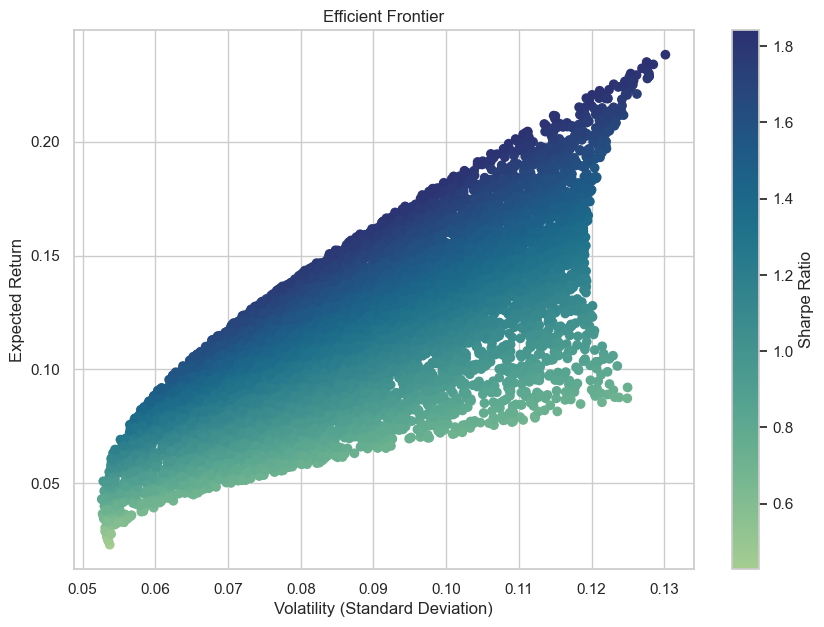

In [8]:
# function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# number of portfolios to simulate
num_portfolios = 10000

# arrays to store the results
results = np.zeros((3, num_portfolios))

# annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

np.random.seed(42)

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0,i] = portfolio_return
    results[1,i] = portfolio_volatility
    results[2,i] = portfolio_return / portfolio_volatility  # Sharpe Ratio

plt.figure(figsize=(10, 7))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='crest', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()

In [9]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]

max_sharpe_return, max_sharpe_volatility, max_sharpe_ratio

(np.float64(0.2114474408919995),
 np.float64(0.11478789983050873),
 np.float64(1.8420708210901533))

In [10]:
max_sharpe_weights = np.zeros(len(unique_tickers))

for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    if results[2, i] == max_sharpe_ratio:
        max_sharpe_weights = weights
        break

portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,BND,0.306254
1,VXUS,0.138495
2,VTI,0.555251


In [11]:
# Function to calculate portfolio performance
def portfolio_performance(weights, returns, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_volatility

# Number of portfolios to simulate
num_portfolios = 10000

# Arrays to store the results
results = np.zeros((3, num_portfolios))

# Annualized covariance matrix
cov_matrix = daily_returns.cov() * 252

# Expected returns (annualized)
expected_returns = daily_returns.mean() * 252

# Seed for reproducibility
np.random.seed(42)

# Simulate portfolios
all_weights = []  # To store weights for all portfolios
for i in range(num_portfolios):
    weights = np.random.random(len(unique_tickers))
    weights /= np.sum(weights)

    portfolio_return, portfolio_volatility = portfolio_performance(weights, expected_returns, cov_matrix)

    results[0, i] = portfolio_return
    results[1, i] = portfolio_volatility
    results[2, i] = portfolio_return / portfolio_volatility  # Sharpe Ratio
    all_weights.append(weights)

# Convert weights to numpy array for easier indexing
all_weights = np.array(all_weights)



In [16]:
all_weights

array([[0.18205878, 0.46212909, 0.35581214],
       [0.65738127, 0.17132261, 0.17129612],
       [0.03807826, 0.56784481, 0.39407693],
       ...,
       [0.73403125, 0.14949401, 0.11647474],
       [0.13674941, 0.48353186, 0.37971873],
       [0.02870195, 0.59157587, 0.37972218]], shape=(10000, 3))

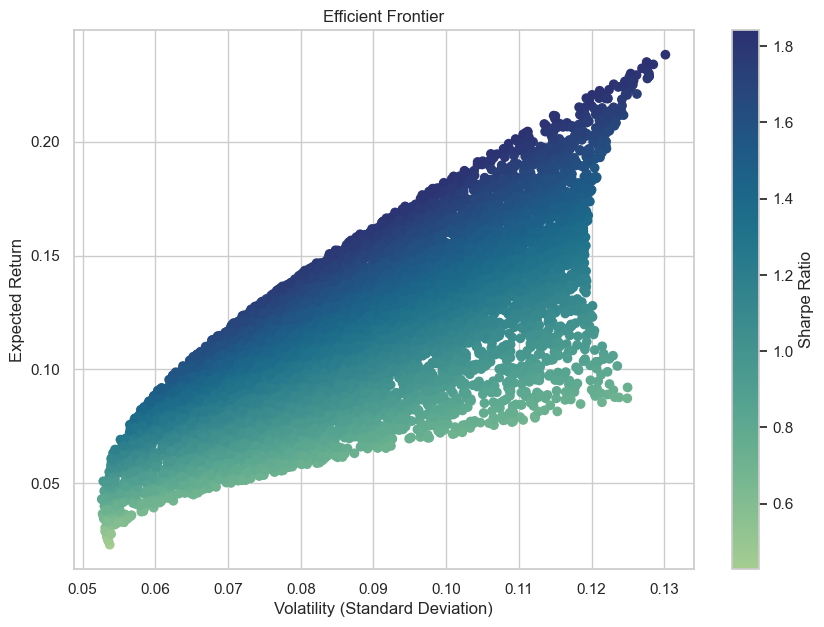

In [12]:
# Plot the efficient frontier
plt.figure(figsize=(10, 7))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='crest', marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)
plt.show()



In [13]:
# Identify the portfolio with the maximum Sharpe ratio
max_sharpe_idx = np.argmax(results[2])
max_sharpe_return = results[0, max_sharpe_idx]
max_sharpe_volatility = results[1, max_sharpe_idx]
max_sharpe_ratio = results[2, max_sharpe_idx]
max_sharpe_weights = all_weights[max_sharpe_idx]

print(f"Max Sharpe Portfolio Return: {max_sharpe_return:.2f}")
print(f"Max Sharpe Portfolio Volatility: {max_sharpe_volatility:.2f}")
print(f"Max Sharpe Portfolio Sharpe Ratio: {max_sharpe_ratio:.2f}")



Max Sharpe Portfolio Return: 0.21
Max Sharpe Portfolio Volatility: 0.11
Max Sharpe Portfolio Sharpe Ratio: 1.84


In [14]:
# Create a DataFrame for weights of the maximum Sharpe portfolio
portfolio_weights_df = pd.DataFrame({
    'Ticker': unique_tickers,
    'Weight': max_sharpe_weights
})

portfolio_weights_df

,Ticker,Weight
0,BND,0.135680
1,VXUS,0.861719
2,VTI,0.002601
